# Car-Price Prediction Project


<img src="car2.jpg" width="300" height="100" />

## 1. Framework

The goal is to predict the price of a car. Let's say we have a website where people can post ad on to sell their used cars. We help the sellers to put a reasonable price with an automatic price recommendation based on the cars features.Luckily, we have an open dataset which contains cars with important features (model, year, mileage etc.) and manifacturer's suggested retail prices. We will use this dataset to build a prediction model.

This is a supervised learning problem since we have the label,  car prices in the dataset and a regression problem since we will predict a value. More specifically, it is a multiple regression problem due to the multiple feature.

To measure the performance of our model, we use Root mean square error (RMSE), a common measure for regression problems.

Attribute Information$^{1}$:

 - make: make of a car (BMV, Toyota, etc) 
 - model: model
 - year: manufacture year  
 - engine_fuel_type: engine fuel type
 - engine_hp: engine horsepower
 - engine_cylinders: number of cylinders
 - transmission_type: automatic or manual 
 - driven_wheels: front, rear, all 
 - number_of_doors: number of doors
 - market_category: luxury, crossover etc. 
 - vehicle_size: compact, midsize, large 
 - vehicle_style: sedan or convertable 
 - highway_mpg: miles per gallon on the highway 
 - city_mpg: miles per gallon in the city  
 - popularity: Frequency of car mentioned on Twitter  
 - msrp: manifacturer's suggested retail price.

<br>

**References**

**1.** Grigorev A.,*Machine Learning Bookcamp*,1st Edition, 2021, Manning Publications Co.,NY.
<br>
**2.** Geron A., *Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow*, 2nd Edition, 2019, O'Reilly Media, Inc.,CA. 
<br>
**3.** Scikit-learn.org
<br>
**4.** Kuhn M., Johnson K., *Feature Engineering and Selection: A Practical Approach for Predictive Models*, 2020, Taylor & Francis Group, LLC.
<br>
**5.** Kuhn M., Johnson K., *Applied Predictive Modelling*, 5th edition, 2013, Springer, NY.


## 2. Download the Data

##### Download the data using kaggle command-line interface (CLI)
I use Jupyter notebook on Windows machine, therefore some linux commands might differ for other machines.

`!pip install kaggle`

Make  .kaggle folder in root directory

`!mkdir ~\.kaggle`

Go to your kaggle.com to your account create a new token, this will download kaggle.json file

`!copy \Users\user\Downloads\kaggle.json \Users\user\.kaggle\kaggle.json`

Make a project folder where you can download the data

`!mkdir car-price`

Make sure that you are in the right directory

`pwd` ('C:\\Users\\user\\car-price')

Download the data

`!kaggle datasets download -d CooperUnion/cardataset`
(Downloading cardataset.zip to C:\Users\user\car-price)

Check the folder to make sure the zipfile ('cardataset.zip') is in there.

`!dir`

Unzip the zipfile. There will be only one file inside, data.csv.

`import zipfile
zip = zipfile.ZipFile('cardataset.zip')
zip.extractall()`


## 3. Preliminary Preparation
#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cd car-price

C:\Users\user\car-price


#### Read the data


In [3]:
df_org=pd.read_csv('data.csv')
#make a copy
df=df_org.copy()
df.head(2)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


#### Make the data uniform
- As we can see above some column names and feature string values are inconsistent, they have underscores, spaces etc..Lets make everything uniform, lowercase (or uppercase) and replace spaces with underscores. I prefer taking care of this step here to make the data exploration easier.

In [4]:
# Make each column name uniform and each value uniform if it is string.
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df = df.applymap(lambda val: val.replace(' ','_').lower() if type(val) == str else val)

#### Check the attribute - data type match

In [5]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

- Lets a create a list from features that needs to be converted from one type to other. Here, the number_of_doors (2,3 or 4) is a categorical attribute and it must have an object type. 



In [6]:
#Convert dtypes from number to object (string).
convert=['number_of_doors']
df[convert] = df[convert].astype(str)

- Is Engine Cylinders categorical attribute?

In [7]:
df['engine_cylinders'].unique()

array([ 6.,  4.,  5.,  8., 12.,  0., nan, 10.,  3., 16.])

- Engine Cylinders is discrete numerical attribute, because it is mathematically meaningfull. More engine cylinders produce more power. But different engine cylinders have different fuel economy and that helps us to make sense above number with one exception, 0.0? It means that some cars has engine without a cylinder? Lets look at only these cars. Below we see that they are electric cars.

In [8]:
df[df['engine_cylinders']== 0.0].head(2)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
539,fiat,500e,2015,electric,NaN,0.0,direct_drive,front_wheel_drive,2.0,hatchback,compact,2dr_hatchback,108,122,819,31800
540,fiat,500e,2016,electric,NaN,0.0,direct_drive,front_wheel_drive,2.0,hatchback,compact,2dr_hatchback,103,121,819,31800


## 4. Quick Overview and Creating a Test Data 

In [9]:
# For a quick data description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_fuel_type   11911 non-null  object 
 4   engine_hp          11845 non-null  float64
 5   engine_cylinders   11884 non-null  float64
 6   transmission_type  11914 non-null  object 
 7   driven_wheels      11914 non-null  object 
 8   number_of_doors    11914 non-null  object 
 9   market_category    8172 non-null   object 
 10  vehicle_size       11914 non-null  object 
 11  vehicle_style      11914 non-null  object 
 12  highway_mpg        11914 non-null  int64  
 13  city_mpg           11914 non-null  int64  
 14  popularity         11914 non-null  int64  
 15  msrp               11914 non-null  int64  
dtypes: float64(2), int64(5

- In this dataframe there are 11914 entries, but, some columns has smaller non-null values showing that we have missing data, especially the market_category column. We also have total 7 numerical dtypes and 9 object. The columns with object type must be hold text attributes since we download the data from CSV file$^{2}$. 

In [10]:
# For a statistical description of the data with numerical attributes 
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
year,11914.0,2010.384338,7.579740,1990.0,2007.0,2015.0,2016.00,2017.0
engine_hp,11845.0,249.386070,109.191870,55.0,170.0,227.0,300.00,1001.0
engine_cylinders,11884.0,5.628829,1.780559,0.0,4.0,6.0,6.00,16.0
highway_mpg,11914.0,26.637485,8.863001,12.0,22.0,26.0,30.00,354.0
city_mpg,11914.0,19.733255,8.987798,7.0,16.0,18.0,22.00,137.0
popularity,11914.0,1554.911197,1441.855347,2.0,549.0,1385.0,2009.00,5657.0
msrp,11914.0,40594.737032,60109.103604,2000.0,21000.0,29995.0,42231.25,2065902.0


- The null values are not included in the statistical calculations of the columns. 
- The percentiles (25%, 50%, 75%) correspond to Q1 (1st Quartile: the bottom 25% of sorted data), Median or Q2 (2nd Quartile:the bottom 50% of sorted data), and Q3 (3rd Quartile: the bottom 75% of sorted data), respectively. For instance, 25% of the cars manufactured before 2007, 50% are before 2015, and 75% of them before 2016. 
-In our target attribute msrp, we see that the std value is higher than the mean value itself!. Std (standart deviation) measures the average distance of each data point from the mean value and, it is greatly affected by the outliers.The max value in the msrp clearly is the furthest outlier. Since the 50% is the median, if we look at the 50% value for the msrp, it is much lower than the mean (ave) value of msrp. Note that the median is not effected by outliers, the mean is, and this is important to remember when replacing the missing values.

- To better understand the distribution of each numerical attributes lets plot the histograms for each.  

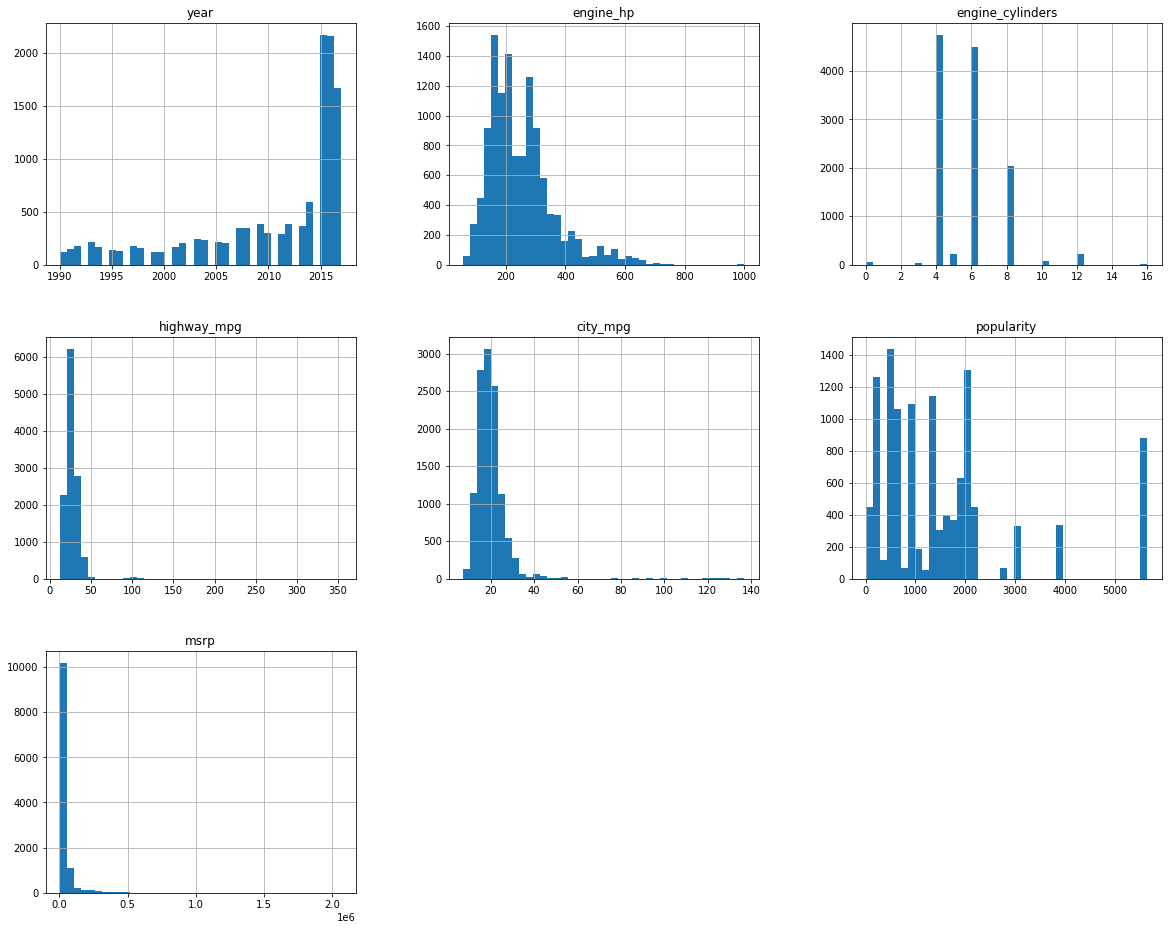

In [11]:
# For more information about the distribution of each numerical attributes,histograms for each.
%matplotlib inline
df.hist(bins=40, figsize=(20,16))
plt.show() 

- A histogram shows attribute values on the horizantal axis and the frequency of these values (count) on the vertical (y) axis.

- For example, year plot shows that majority of cars made in 2015 and later, relatively new cars. Recall form the df.describe(), the median(50%) for year is 2015. We could say that this plot has tail on the left or it is skewed left. 

- We also have skewed right (tail right) distributions. Lets look at the msrp. Tail right indicates that we have outliers on the right. Since the msrp values are manifacturer's suggested retail prices and our target/labels, later we will further examine properties of this distribution. Skewed distrubitions are hard for some ML models to detect patterns and we will want transform them more normal (bell-shaped) distributions of the dependent variable$^{2}$. 

- Our dependent variable (target), y is the value (msrp) we want to understand to predict.

- To see the tail better in msrp histogram, we will plot it again with displot() with the kernel density estimation. The displot() function also creates histogram by default parameter kind='hist'. In addition to we can adjust and add parameters such as log_scale and kde (kernel density estimation). 

#### Create a Test Data
- So far, we looked at the whole dataset, made the data string values and column names uniform 
and changed a dtype from number to an object for an attribute. 
None of these should cost data leakage since there is nothing to effect choices about the model. However, before continuing with the remaining data pre-processing, we must split the data.

In [12]:
from sklearn.model_selection import train_test_split

# 15% of data is separated hold out test set..
df_train,df_test  = train_test_split(df, test_size=0.15, random_state=42)


## 4. Data Exploration and Making Decisions for Data Preparation
### Study the Missing Values
#### Percantage of missing values

In [13]:
# We will remove a column if it has more than %25 null values
missing_percent= df_train.isnull().sum() * 100 / len(df_train)
missing_percent[missing_percent >0]

engine_fuel_type     0.029627
engine_hp            0.543156
engine_cylinders     0.227138
market_category     31.404306
dtype: float64

- The target variable (msrp) is not in the list, no missing values. 
- Market category has more than 30% missing. We will drop the market_category.
- This is the only cleaning action we take here, we will clean the data in the next section.

#### Dropping the columns with too many nulls

In [14]:
#Create a list of columns with null values higher than a threshold and drop them
null_cols = missing_percent[missing_percent > 25].keys().tolist()
df_train.drop(null_cols, axis=1, inplace= True)

#### Replacing missing values in numerical features
- Here, the engine_hp and engine_cylinders are numerical and we can use their median, however, we do not know if the test data has missing values in other features. To be safe, we will use Scikit-Learn's SimpleImputer to replace the missing values with their median for the all numerical columns.

#### Replacing missing values in categorical features

- The engine_fuel_type is categorical, we can use either the most frequent category, or use Scikit-Learn's SimpleImputer to replace the missing values whichever option we prefer. If we choose strategy == “constant”, the fill_value argument is used to replace all occurrences of missing_values. If left to the default, fill_value will be 0 when imputing numerical data and “missing_value” for strings or object data types$^{3}$. 


- Below looking at the categories in engine_fuel_type, 
most frequent category, regular_unleaded is the almost 60%  of the whole data,but to be safe, we will use Scikit-Learn's SimpleImputer with strategy == “constant”.


- For the other possible categorical missing values in the test data,since we do not know if the test data has missing values in other categorical variables, we will use the imputer for the all categorical columns.

In [15]:
#value count as percentages
df_train['engine_fuel_type'].value_counts(normalize=True)

regular_unleaded                                0.602489
premium_unleaded_(required)                     0.171589
premium_unleaded_(recommended)                  0.127235
flex-fuel_(unleaded/e85)                        0.073694
diesel                                          0.013040
electric                                        0.004840
flex-fuel_(premium_unleaded_required/e85)       0.004149
flex-fuel_(premium_unleaded_recommended/e85)    0.002173
flex-fuel_(unleaded/natural_gas)                0.000593
natural_gas                                     0.000198
Name: engine_fuel_type, dtype: float64

### Understanding the target variable

<Figure size 4000x3200 with 0 Axes>

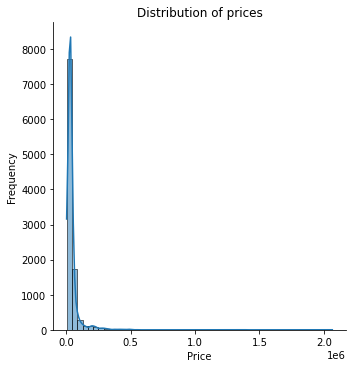

In [16]:
plt.figure(figsize=(20,16), dpi=200)
sns.displot(df_train['msrp'], bins=50, kde=True)
plt.title('Distribution of prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

- One way to remove the long tail in the distribution is the computing the logarithm of the attribute.
This will create a normal-bell shape distribution for the machine learning algorithms. We will perform log transformation on the msrp values.
Take a closer look at msrp.



<Figure size 3200x2000 with 0 Axes>

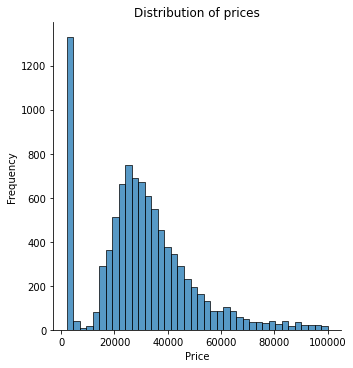

In [17]:
#Above, the msrp histogram has a long tail
plt.figure(figsize=(16,10), dpi=200)
sns.displot(df_train[df_train['msrp']<100000]['msrp'], bins=40)
plt.title('Distribution of prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

- Here we are only looking at the distibution the prices less than $100000. Most noticable is that the highest peak around min price which we know it is 2000 from df.describe() above. Even just with around the min value there are more than 1000 cars are sold, try `len(df_trainval[df_trainval['msrp'] ==2000])`.

- Right tail has the expensive car prices. Because of the nature of this skewed distribution we must be careful when separate a test data that random sampling won't choose far right or far left. But because the number of our data set is relatively larger than  the number of attributes$^{2}$ we simply used Scikit-Learn's train_test_split() function. 

- The outliers are extremely expensive cars. Lets check the features for the most expensive car.

In [18]:
#Most expensive car in the data
df_train[df_train['msrp']==df_train['msrp'].max()]


,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
11362,bugatti,veyron_16.4,2008,premium_unleaded_(required),1001.0,16.0,automated_manual,all_wheel_drive,2.0,compact,coupe,14,8,820,2065902


- To understand the relationships between the attributes, we want to plot each pair, but we have 7 numerical attributes, 7x7=49 plots is difficult to examine. Lets choose the attributes that are more correlated to target. 



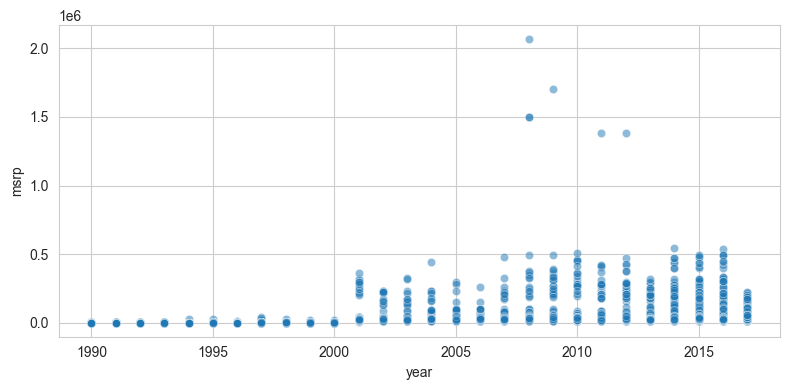

In [19]:
plt.figure(figsize=(8,4), dpi=100)
sns.set_style("whitegrid")
sns.scatterplot(x='year', y='msrp', data=df_train, alpha=0.5)
plt.tight_layout()

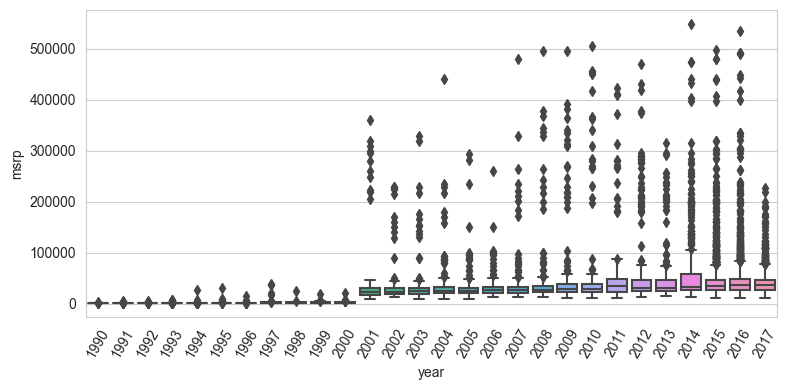

In [20]:
plt.figure(figsize=(8,4), dpi=100)
sns.set_style("whitegrid")
ax=sns.boxplot(x='year', y='msrp', data=df_train[df_train['msrp'] <=1000000])
plt.setp(ax.get_xticklabels(), rotation=60)
plt.tight_layout()

- Some extreme values is seen (natural outliers), but these can occur with much lower probabilities, still to be safe I like to keep them.

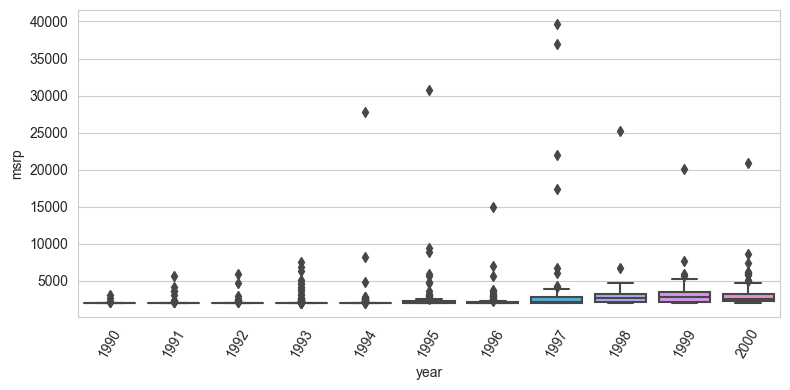

In [21]:
plt.figure(figsize=(8,4), dpi=100)
sns.set_style("whitegrid")
ax=sns.boxplot(x='year', y='msrp', data=df_train[df_train['year'] <= 2000])
plt.setp(ax.get_xticklabels(), rotation=60)
plt.tight_layout()

In [22]:
first_outliers=df_train[(df_train['year'] <= 2000) & (df_train['msrp'] > 8000)]
second_outliers= df_train[df_train['msrp'] > 500000]
outliers_2001=df_train[(df_train['year'] == 2001) & (df_train['msrp'] > 200000)]
extreme_outliers=pd.concat([first_outliers, second_outliers,outliers_2001], ignore_index=False)

### Studying Correlations
#### Looking for Correlations in Numerical Attributes

In [23]:
corr_matrix= df_train.corr()

#Correlation of each attribute with MSRP
corr_matrix['msrp'].sort_values(ascending=False)

msrp                1.000000
engine_hp           0.652882
engine_cylinders    0.528969
year                0.220804
popularity         -0.049816
highway_mpg        -0.161464
city_mpg           -0.164715
Name: msrp, dtype: float64

- The most promising attributes to predict the msrp are 'engine_hp',  'engine_cylinders' and 'year'. Lets visualize 
these attributes relationships.

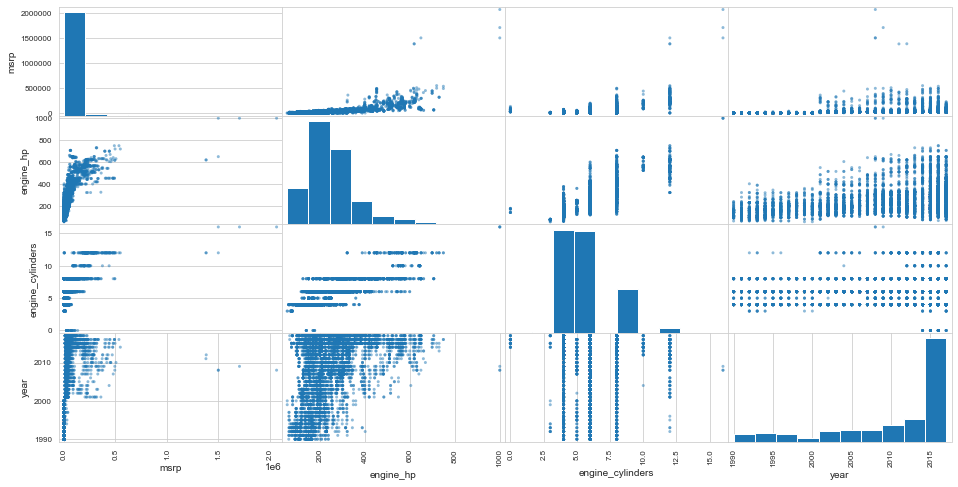

In [24]:
from pandas.plotting import scatter_matrix
attributes=['msrp', 'engine_hp','engine_cylinders','year' ]
scatter_matrix(df_train[attributes],figsize = (16, 8))
plt.show()

- Above the diagonal from top left to bottom right shows histogram of each attribute.  Here we see that some attributes
are correlated each other, especially 'engine_hp' and 'engine_cylinders'. Below lets look at the correlation coefficients,
as we defined earlier corr_matrix= df_trainval.corr()

In [25]:
corr_matrix

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,popularity,msrp
year,1.000000,0.352719,-0.038273,0.259041,0.202380,0.073101,0.220804
engine_hp,0.352719,1.000000,0.782584,-0.407450,-0.452011,0.038353,0.652882
engine_cylinders,-0.038273,0.782584,1.000000,-0.615713,-0.606264,0.043960,0.528969
highway_mpg,0.259041,-0.407450,-0.615713,1.000000,0.872703,-0.023812,-0.161464
city_mpg,0.202380,-0.452011,-0.606264,0.872703,1.000000,-0.008521,-0.164715
popularity,0.073101,0.038353,0.043960,-0.023812,-0.008521,1.000000,-0.049816
msrp,0.220804,0.652882,0.528969,-0.161464,-0.164715,-0.049816,1.000000


- These coefficients are by default pearson : standard correlation coefficient, they take values between -1 and +1. 
Positive and negatives signs indicates positive and negative associations. Coeffients closer to zero indicate weak association.
Lets only look at features, their correlation matrix with heatmap.

<AxesSubplot:>

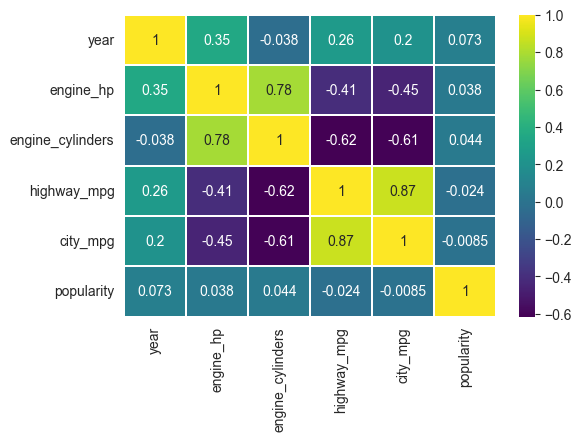

In [26]:
plt.figure(figsize=(6,4), dpi=100)
sns.heatmap(df_train.drop('msrp',axis=1).corr(), cmap='viridis', annot=True, linewidth=0.2)

- The heatmap shows that the brighter the color is more positive the association, the darker the color is
more negative the association. The correlation threshold is arbitrary and may need to be raised or lowered depending on the problem and the models to be used$^{4}$. 


- It is suggested for the models sensitive to between-predicter correlations,
a threshold of 0.75 might be applied$^{5}$. 


- As seen from the heatmap, the correlations 0.87 and 0.78 must be taken care of for 'city_mpg'-'highway_mpg and 'engine_hp'-'engine_cylinders', respectively. 


- Since the more cylinders an engine has, the more horsepower$^{6}$ is, we can drop one of these predictors. Lets make an empty drop_cols list and append 'engine_cylinders' to the list.


In [27]:
drop_cols=[]
drop_cols.append('engine_cylinders')

- For the city_mpg and highway_mpg, instead of choosing one of them, we can use a new variable that accounts the both attribute. This new feature is called 'combined_mpg'.


- According to https://www.meridianhonda.com to calculate combined MPG, manufacturers assign a percentage value to city and highway MPGs. City MPG is valued at 55% and highway MPG is valued at 45% and, they are combined. The resulting number is roughly in the middle of the city and highway MPGs, with the city MPG valued a little higher because most people spend more time navigating urban areas than driving on highways. Lets create a new variable, combined_mpg to check how correlated is with the msrp? 


In [28]:
df_train['combined_mpg']= df_train['city_mpg']*0.55+ df_train['highway_mpg']*0.45
df_train.corr()['msrp'].sort_values(ascending=False)

msrp                1.000000
engine_hp           0.652882
engine_cylinders    0.528969
year                0.220804
popularity         -0.049816
highway_mpg        -0.161464
city_mpg           -0.164715
combined_mpg       -0.168647
Name: msrp, dtype: float64

- That is great, combined_mpg is slightly higher than the city and highway mpg alone!
We can remove the predictors city_mpg and highway_mpg and, since now we have the new variable, combined_mpg instead. Lets add city_mpg and highway_mpg to the drop_cols.

In [29]:
drop_cols.extend(['city_mpg','highway_mpg'])
# Lets add 'year'to the drop_cols and we will create a new attribute age of car.
drop_cols.append('year')
df_train['age']=2017- df_train['year']

### Looking for Correlations in Categorical Attributes

In [30]:
cat_cols=df_train.select_dtypes(include= 'object').columns.tolist()
df_train[cat_cols].head()

,make,model,engine_fuel_type,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style
10403,hyundai,tiburon,regular_unleaded,manual,front_wheel_drive,2.0,compact,2dr_hatchback
6478,lexus,ls_430,premium_unleaded_(required),automatic,rear_wheel_drive,4.0,large,sedan
333,nissan,370z,premium_unleaded_(required),manual,rear_wheel_drive,2.0,compact,coupe
2879,bentley,continental_gtc_speed,flex-fuel_(premium_unleaded_required/e85),automatic,all_wheel_drive,2.0,midsize,convertible
10129,suzuki,sx4,regular_unleaded,manual,front_wheel_drive,4.0,compact,4dr_hatchback


In [31]:
{column:len(df_train[column].unique()) for column in cat_cols}

{'make': 48,
 'model': 905,
 'engine_fuel_type': 11,
 'transmission_type': 5,
 'driven_wheels': 4,
 'number_of_doors': 4,
 'vehicle_size': 3,
 'vehicle_style': 16}

- I like to drop if a category has too many unique values, as a threshold if the max frequency is less than 1.5%, 
we will add the column to the drop_cols list.

In [32]:
#Max frequency and drop it if less than 1.5%.
#max(df_train['model'].value_counts(normalize=True)*100)
drop_cols.append('model')

- For the 'make' variable lets take top 10 most frequent values and as categories.

In [33]:
df_train['make']= df_train['make'].mask(df_train['make'].map(df_train['make'].value_counts(normalize=True)) < 0.03, 'other')

In [34]:
df_train['engine_fuel_type']= df_train['engine_fuel_type'].mask(df_train['engine_fuel_type'].map(df_train['engine_fuel_type'].value_counts(normalize=True)) < 0.03, 'other_fuel_type')

In [35]:
df_train['transmission_type']= df_train['transmission_type'].mask(df_train['transmission_type'].map(df_train['transmission_type'].value_counts(normalize=True)) < 0.03, 'other_type')

In [36]:
df_train['vehicle_style']= df_train['vehicle_style'].mask(df_train['vehicle_style'].map(df_train['vehicle_style'].value_counts(normalize=True)) < 0.03, 'other_style')

#### Looking at the relationship between categorical variables and manifacturer's suggested retail prices, msrp.

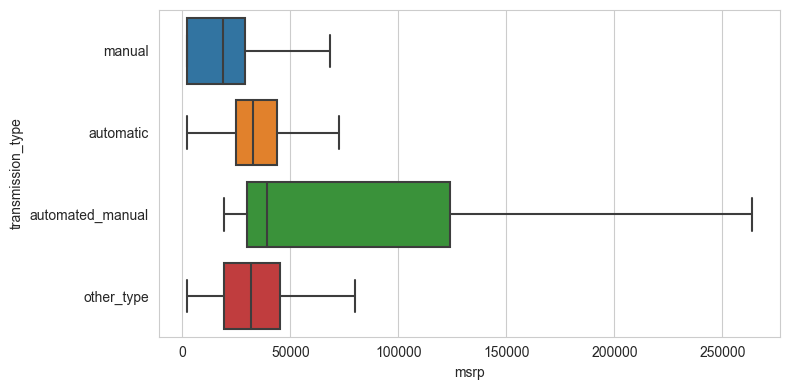

In [37]:
plt.figure(figsize=(8,4), dpi=100)
sns.set_style("whitegrid")
sns.boxplot(y='transmission_type', x='msrp', data=df_train, showfliers=False)
plt.tight_layout()

- We see that the most expensive cars have automated_manual transmission, after the some with unknown transmission type,
some manual cars are the cheapest.

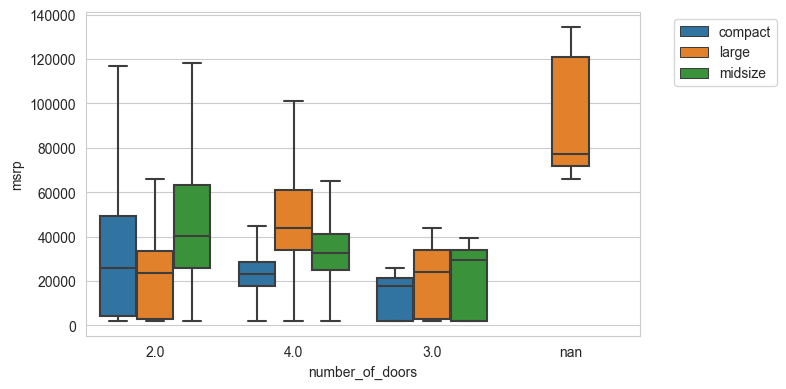

In [38]:
plt.figure(figsize=(8,4), dpi=100)
sns.set_style("whitegrid")
sns.boxplot(x='number_of_doors', y='msrp', data=df_train, hue='vehicle_size', showfliers=False)
#plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()

In [39]:
df_train[df_train['number_of_doors']=='nan']

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,combined_mpg,age
6930,other,model_s,2016,other_fuel_type,NaN,0.0,other_type,all_wheel_drive,nan,large,sedan,105,102,1391,79500,103.35,1
6931,other,model_s,2016,other_fuel_type,NaN,0.0,other_type,all_wheel_drive,nan,large,sedan,101,98,1391,66000,99.35,1
6932,other,model_s,2016,other_fuel_type,NaN,0.0,other_type,all_wheel_drive,nan,large,sedan,105,92,1391,134500,97.85,1
6934,other,model_s,2016,other_fuel_type,NaN,0.0,other_type,all_wheel_drive,nan,large,sedan,107,101,1391,71000,103.70,1
6933,other,model_s,2016,other_fuel_type,NaN,0.0,other_type,rear_wheel_drive,nan,large,sedan,100,97,1391,74500,98.35,1
4666,other,ff,2013,premium_unleaded_(required),651.0,12.0,automated_manual,all_wheel_drive,nan,large,coupe,16,11,2774,295000,13.25,4


- We see that most expensive cars with number_of_doors missing are new large, high performance cars, mostly 1 year old electric cars. 

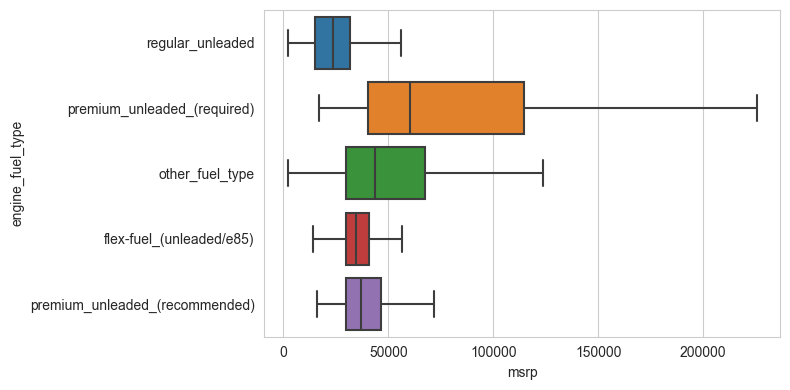

In [40]:
plt.figure(figsize=(8,4), dpi=100)
sns.set_style("whitegrid")
sns.boxplot(y='engine_fuel_type', x='msrp', data=df_train, showfliers=False)
plt.tight_layout()

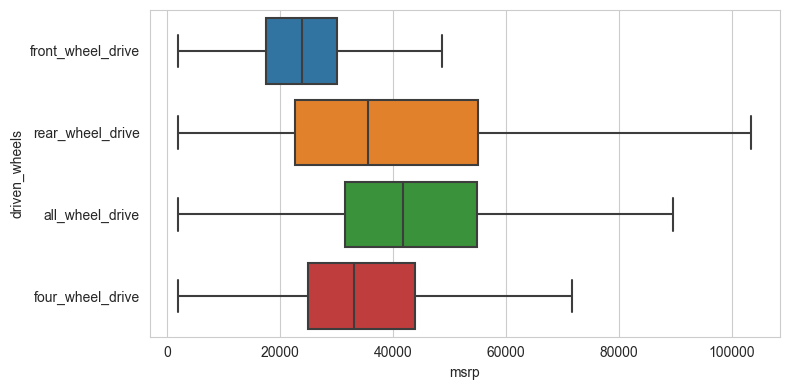

In [41]:
plt.figure(figsize=(8,4), dpi=100)
sns.set_style("whitegrid")
sns.boxplot(y='driven_wheels', x='msrp', data=df_train, showfliers=False)
plt.tight_layout()

## 5. Data Preparation for Machine Learning Algorithms   

### Separate the Predictors and the Label¶
First, separate the data for X and y, predictors and target, respectively.


In [42]:
df_train= df_train.drop(extreme_outliers.index)

In [43]:
X = df_train.drop('msrp', axis=1) #Feature data frame
y= df_train['msrp'] #target

### Data Cleaning
#### Drop the previously chosen columns, drop_cols

In [44]:
X.drop(drop_cols, axis=1, inplace=True)

###  Creating Tranformation Pipelines

In [45]:
# Separate the feature data into numerical and categorical sections
X_num= X.select_dtypes(include= 'number')
X_cat= X.select_dtypes(include= 'object')
num_attribs=list(X_num)
cat_attribs=list(X_cat)

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#### Pipeline for Numerical Features

In [47]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy ='median')),
    ('std_scaler', StandardScaler()),
])

#### Pipeline for Categorical Features
- We will convert them to numeric using onehot encoding below.

In [48]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

### Full Preprocessing Pipeline 

In [49]:
from sklearn.compose import ColumnTransformer

In [50]:
full_preprocessing =ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline,cat_attribs),
])

### Transformation of Target variable

In [51]:
y_prepared= np.log1p(y)

## 6.  Training and  Evaluation of a Shortlist of Promising Models
### Linear Regression Model
#### Model Training

In [52]:
from sklearn.linear_model import LinearRegression
#model=LinearRegression()

In [53]:
lin_pipeline = Pipeline([
    ('pre',full_preprocessing),
    ('model', LinearRegression())]
)

In [54]:
from sklearn.model_selection import cross_validate
lin_scores= cross_validate(lin_pipeline, X, y_prepared, cv=5, scoring=['neg_root_mean_squared_error', 'r2'], return_train_score=True)
print(pd.DataFrame(lin_scores).mean().round(2))

fit_time                             0.19
score_time                           0.03
test_neg_root_mean_squared_error    -0.45
train_neg_root_mean_squared_error   -0.45
test_r2                              0.83
train_r2                             0.83
dtype: float64


In [55]:
mean_y_train=round(y_prepared.mean(),2)
median_y_train=round(y_prepared.median(),2)
print('mean:', mean_y_train) 
print('median:', median_y_train) 

mean: 10.11
median: 10.31


In [56]:
lin_pipeline.fit(X, y_prepared);

In [57]:
y_pred=lin_pipeline.predict(X);

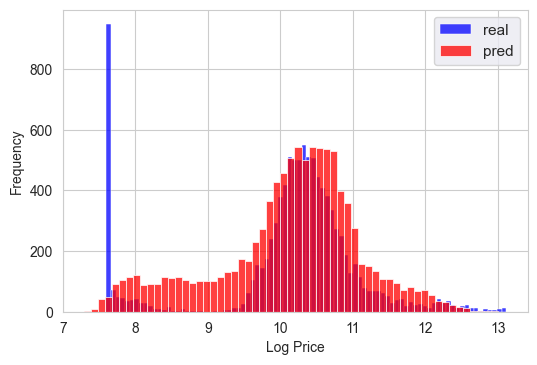

In [58]:
plt.figure(figsize=(6,4), dpi=100)
sns.histplot(y_prepared,color="blue" ,label="real")
sns.histplot(y_pred,color="red", label='pred')
sns.set(style='darkgrid')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Polynomial Regression

In [59]:
from sklearn.preprocessing import PolynomialFeatures

In [60]:
poly_pipeline = Pipeline([
    ('pre',full_preprocessing),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())]
)

In [61]:
poly_scores= cross_validate(poly_pipeline, X, y_prepared, cv=5, scoring=['neg_root_mean_squared_error', 'r2'], return_train_score=True)
print(pd.DataFrame(poly_scores).mean().round(2))

fit_time                             12.01
score_time                            0.05
test_neg_root_mean_squared_error     -0.39
train_neg_root_mean_squared_error    -0.27
test_r2                               0.84
train_r2                              0.94
dtype: float64


### Ridge Regression

In [62]:
from sklearn.linear_model import Ridge

In [63]:
ridge_pipeline = Pipeline([
    ('pre',full_preprocessing),
    ('poly', PolynomialFeatures(degree=2)),
    ('model',Ridge() )]
)

In [64]:
ridge_scores= cross_validate(ridge_pipeline, X, y_prepared, cv=5, scoring=['neg_root_mean_squared_error', 'r2'], return_train_score=True)
print(pd.DataFrame(ridge_scores).mean().round(2))

fit_time                             1.63
score_time                           0.20
test_neg_root_mean_squared_error    -0.30
train_neg_root_mean_squared_error   -0.27
test_r2                              0.93
train_r2                             0.94
dtype: float64


In [65]:
ridge_pipeline.fit(X, y_prepared);
y_pred=ridge_pipeline.predict(X);

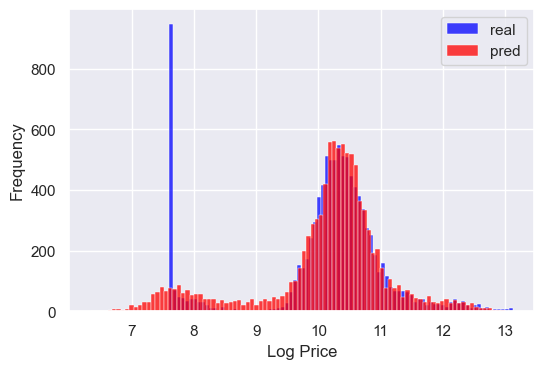

In [66]:
plt.figure(figsize=(6,4), dpi=100)
sns.histplot(y_prepared,color="blue" ,label="real")
sns.histplot(y_pred,color="red", label='pred')
sns.set(style='darkgrid')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

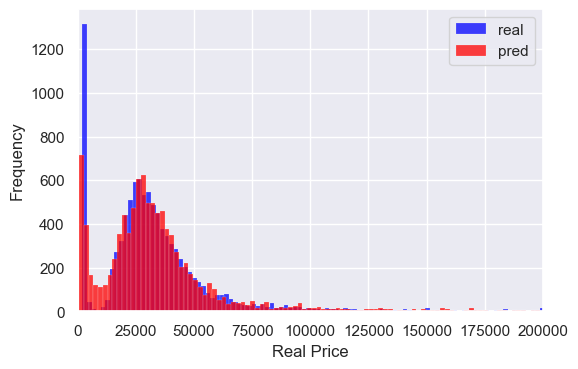

In [67]:
plt.figure(figsize=(6,4), dpi=100)
sns.histplot(y,color="blue" ,label="real")
sns.histplot(np.expm1(y_pred),color="red", label='pred')
sns.set(style='darkgrid')
plt.xlabel('Real Price')
plt.ylabel('Frequency')
plt.xlim(0,200000)
plt.legend()
plt.show()

### Random Forests 


In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
forest_pipeline = Pipeline([
    ('pre',full_preprocessing),
    ('model',RandomForestRegressor() )]
)

In [70]:
forest_scores= cross_validate(forest_pipeline, X, y_prepared, cv=5, scoring=['neg_root_mean_squared_error', 'r2'], return_train_score=True)
print(pd.DataFrame(forest_scores).mean().round(3))

fit_time                             45.226
score_time                            0.206
test_neg_root_mean_squared_error     -0.103
train_neg_root_mean_squared_error    -0.061
test_r2                               0.991
train_r2                              0.997
dtype: float64


In [71]:
forest_pipeline.fit(X, y_prepared);
y_pred=forest_pipeline.predict(X);

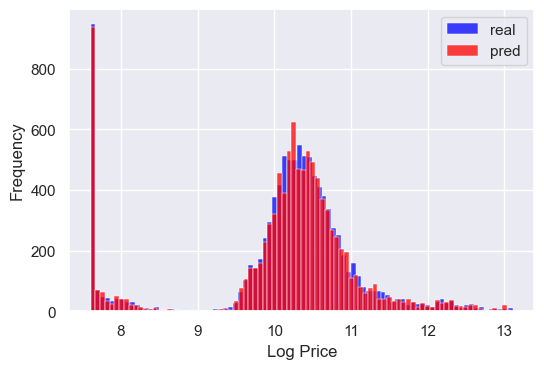

In [72]:
plt.figure(figsize=(6,4), dpi=100)
sns.histplot(y_prepared,color="blue" ,label="real")
sns.histplot(y_pred,color="red", label='pred')
sns.set(style='darkgrid')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

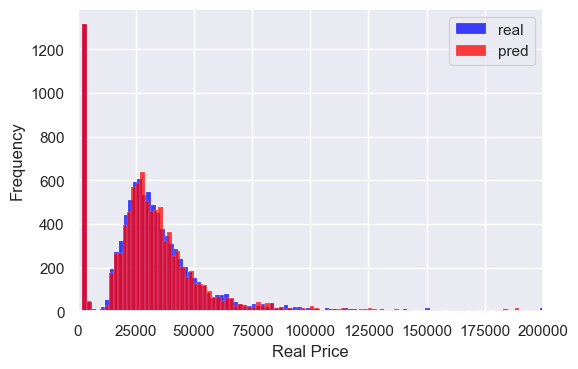

In [73]:
plt.figure(figsize=(6,4), dpi=100)
sns.histplot(y,color="blue" ,label="real")
sns.histplot(np.expm1(y_pred),color="red", label='pred')
sns.set(style='darkgrid')
plt.xlabel('Real Price')
plt.ylabel('Frequency')
plt.xlim(0,200000)
plt.legend()
plt.show()

In [74]:
#param_grid = [{'randomforestregressor__n_estimators':[3,10,30], 'randomforestregressor__max_features':[2,4,6,8]},{'randomforestregressor__bootstrap':[False], 'randomforestregressor__n_estimators':[3,10],'randomforestregressor__max_features':[2,3,4]},]

### 7. Fine Tuning 

In [75]:
from sklearn.model_selection import GridSearchCV

#forest_pipeline.get_params().keys()
param_grid=[{'model__n_estimators':[3,10,30], 'model__max_features': [2,4,6,8]}, 
           {'model__bootstrap': [False],'model__n_estimators':[3,10], 'model__max_features': [2,3,4]},
           ]

In [76]:
grid_search=GridSearchCV(forest_pipeline, param_grid, cv=5, scoring='neg_median_absolute_error', return_train_score=True)

In [77]:
grid_search.fit(X, y_prepared);

In [78]:
grid_search.best_params_

{'model__max_features': 8, 'model__n_estimators': 30}

In [79]:
final_model=grid_search.best_estimator_

In [80]:
grid_scores= cross_validate(final_model, X, y_prepared, cv=5, scoring=['neg_root_mean_squared_error', 'r2'], return_train_score=True)
print(pd.DataFrame(grid_scores).mean().round(3))

fit_time                             4.623
score_time                           0.053
test_neg_root_mean_squared_error    -0.112
train_neg_root_mean_squared_error   -0.065
test_r2                              0.989
train_r2                             0.996
dtype: float64


In [81]:
y_pred= final_model.predict(X)

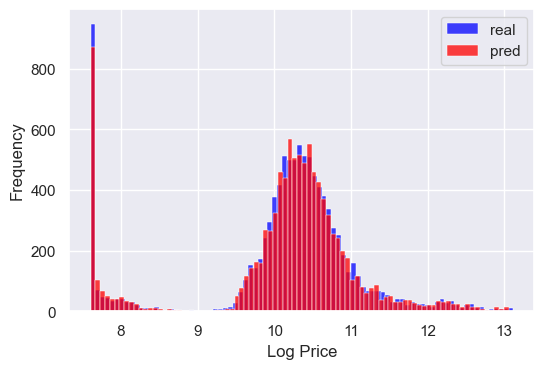

In [82]:
plt.figure(figsize=(6,4), dpi=100)
sns.histplot(y_prepared,color="blue" ,label="real")
sns.histplot(y_pred,color="red", label='pred')
sns.set(style='darkgrid')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

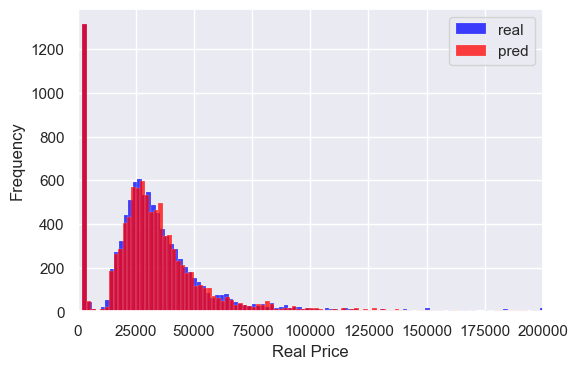

In [83]:
plt.figure(figsize=(6,4), dpi=100)
sns.histplot(y,color="blue" ,label="real")
sns.histplot(np.expm1(y_pred),color="red", label='pred')
sns.set(style='darkgrid')
plt.xlabel('Real Price')
plt.ylabel('Frequency')
plt.xlim(0,200000)
plt.legend()
plt.show()

### 8. Testing the Model Performance

In [84]:
final_model=grid_search.best_estimator_


#### Dropping the columns with too many nulls

In [85]:
# drop the null_cols
df_test.drop(null_cols, axis=1, inplace= True)
#add the new features
df_test['age']=2017- df_test['year']
df_test['combined_mpg']= df_test['city_mpg']*0.55+ df_test['highway_mpg']*0.45
df_test['make']= df['make'].mask(df_test['make'].map(df_test['make'].value_counts(normalize=True)) < 0.03, 'other')
df_test['engine_fuel_type']= df_test['engine_fuel_type'].mask(df_test['engine_fuel_type'].map(df_test['engine_fuel_type'].value_counts(normalize=True)) < 0.03, 'other_fuel_type')
df_test['transmission_type']= df_test['transmission_type'].mask(df_test['transmission_type'].map(df_test['transmission_type'].value_counts(normalize=True)) < 0.03, 'other_type')
df_test['vehicle_style']= df_test['vehicle_style'].mask(df_test['vehicle_style'].map(df_test['vehicle_style'].value_counts(normalize=True)) < 0.03, 'other_style')

#### Prepare the test data

In [86]:
#separate the variables
X_test = df_test.drop('msrp', axis=1) #Feature data frame
y_test= df_test['msrp'] #target
#drop the drop_cols
X_test.drop(drop_cols, axis=1, inplace=True)
#transform the msrp
y_test_prepared= np.log1p(y_test)

In [87]:
final_predictions=final_model.predict(X_test)

In [88]:
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error

In [89]:
# Root mean squared error
final_rmse=mean_squared_error(y_test_prepared, final_predictions, squared=False)
final_r2=r2_score(y_test_prepared, final_predictions)
final_mdae=median_absolute_error(y_test_prepared, final_predictions)
print('median:', round(np.median(y_test_prepared),2))
print('predicted_median:', round(np.median(final_predictions),2))
print('mean:', round(np.mean(y_test_prepared),2))
print('predicted_mean:', round(np.mean(final_predictions),2))
print('final_rmse:', round(final_rmse,2))
print('final_r2:', final_r2.round(2))

median: 10.3
predicted_median: 10.3
mean: 10.08
predicted_mean: 10.07
final_rmse: 0.13
final_r2: 0.99


In [90]:
real_final_predictions= np.expm1(final_predictions)
real_retail_price= np.expm1(y_test_prepared)
real_final_rmse=mean_squared_error(real_retail_price, real_final_predictions, squared=False)
real_final_r2=r2_score(real_retail_price, real_final_predictions)
print('real_mean:', round(np.mean(real_retail_price),2))
print('real_predicted_mean:', round(np.mean(real_final_predictions),2))
print('real_median:', round(np.median(real_retail_price),2))
print('real_predicted_median:', round(np.median(real_final_predictions),2))

real_mean: 39219.18
real_predicted_mean: 37680.26
real_median: 29722.5
real_predicted_median: 29756.84


## 9. Model Deployment

#### Saving the Model

In [91]:
import joblib

In [92]:
joblib.dump(final_model, 'final_model_car.pkl')

['final_model_car.pkl']